In [17]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch 
import torch.nn as nn
import torch.optim as optim

In [18]:
torch.manual_seed(42)

In [19]:
import pandas as pd

df=pd.read_csv('datasets/fashion-mnist_test.csv/fashion-mnist_test.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

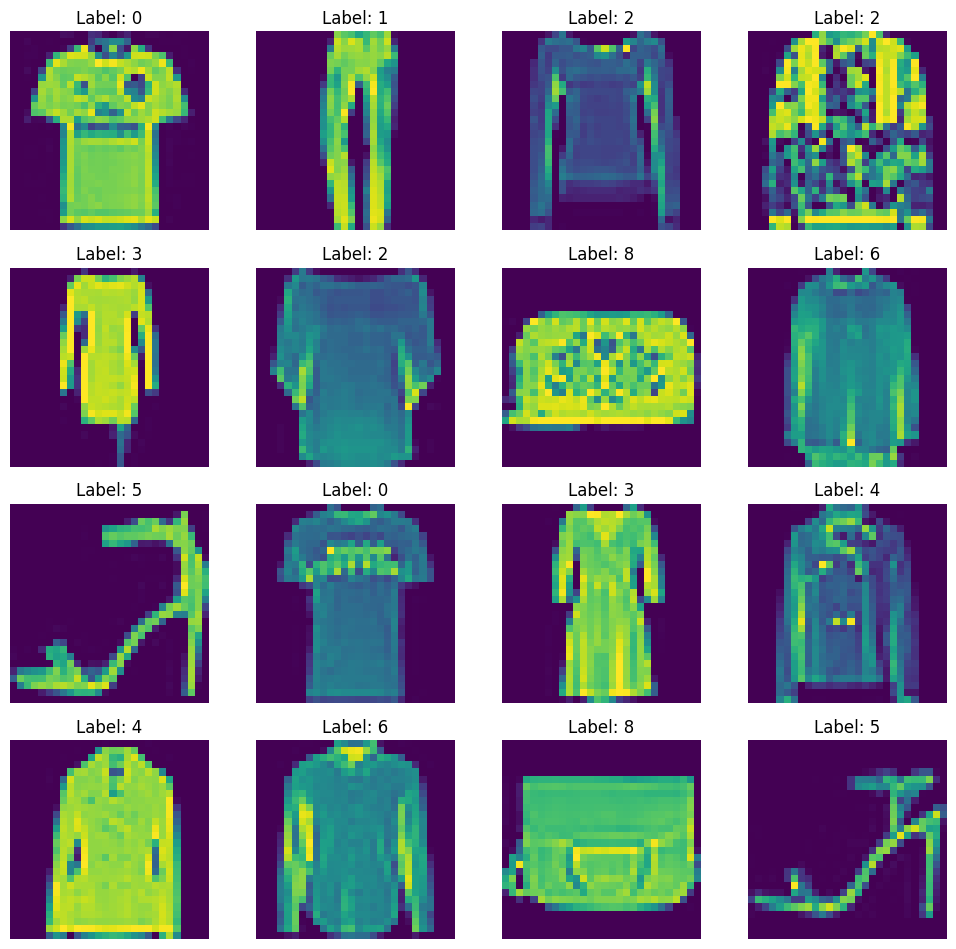

In [21]:
fig,axes= plt.subplots(4,4,figsize=(10,10) )
for i, ax in enumerate(axes.flat):
    img=df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Label: {df.iloc[i,0]}")

plt.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [22]:
X=df.iloc[:,1:].values
y=df.iloc[:,0].values


In [23]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [24]:
X_train=X_train/250
X_test=X_test/250

In [25]:
#custom datset

class CustomDataset(Dataset):

    def __init__(self,features,labels):
        self.features=torch.tensor(features, dtype=torch.float32)   
        self.labels=torch.tensor(labels,dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self,index):
        return self.features[index],self.labels[index]

In [26]:
#create train dataset object

train_dataset=CustomDataset(X_train, y_train)
test_dataset=CustomDataset(X_test,y_test)

In [27]:
#create train and test loader
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=False)

In [28]:
#define nn class

class MyNN(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_layers,neurons_per_layer):
        super().__init__()
        layers=[]

        for i in range(hidden_layers):
            layers.append(nn.Linear(input_dim,neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(p=0.3))
            input_dim=neurons_per_layer

        layers.append(nn.Linear(neurons_per_layer,output_dim))

        self.model=nn.Sequential(*layers)

    def forward(self,x):
        return self.model(x)

In [30]:
def objective(trail):

    num_hidden_layers=trail.suggest_int("hidden_layers",1,5)
    neurons_per_Layer=trail.suggest_int("neurons_per_layers",8,128,step=8)

    input_dim=784
    output_dim=10

    model=MyNN(input_dim,output_dim,num_hidden_layers,neurons_per_Layer).to(device)

    #params init
    epochs=100
    learning_rate=0.1

    #optimizer
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.SGD(model.parameters(),lr=learning_rate,weight_decay=1e-4)

    #training loop

    for epochs in range(epochs):
        for batch_features,batch_labels in train_loader:
            #move data to gpu
            batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

            y_pred=model(batch_features)

            loss=criterion(y_pred,batch_labels)

            #calculate loss
            optimizer.zero_grad()
            loss.backward()
            #updating gradient
            optimizer.step()

    model.eval()

    total=0
    correct=0


    with torch.no_grad():
        for batch_features,batch_labels in test_loader:
            batch_features,batch_labels =batch_features.to(device),batch_labels.to(device)

            outputs=model(batch_features)

            _,predicted=torch.max(outputs,1)
            total=total+batch_labels.shape[0]

            correct=correct+(predicted==batch_labels).sum().item()

        
        accuracy=correct/total
        
        return accuracy  

In [32]:
import optuna
study=optuna.create_study(direction='maximize')

[I 2025-09-12 18:32:57,286] A new study created in memory with name: no-name-8c876030-a1d3-4efd-a95a-a93e7bbabacf


In [33]:
study.optimize(objective,n_trials=10)

[I 2025-09-12 18:35:20,080] Trial 0 finished with value: 0.84 and parameters: {'hidden_layers': 4, 'neurons_per_layers': 40}. Best is trial 0 with value: 0.84.
[I 2025-09-12 18:37:06,463] Trial 1 finished with value: 0.8615 and parameters: {'hidden_layers': 1, 'neurons_per_layers': 120}. Best is trial 1 with value: 0.8615.
[I 2025-09-12 18:39:16,333] Trial 2 finished with value: 0.8335 and parameters: {'hidden_layers': 2, 'neurons_per_layers': 16}. Best is trial 1 with value: 0.8615.
[I 2025-09-12 18:42:43,523] Trial 3 finished with value: 0.8485 and parameters: {'hidden_layers': 4, 'neurons_per_layers': 104}. Best is trial 1 with value: 0.8615.
[I 2025-09-12 18:46:26,329] Trial 4 finished with value: 0.8575 and parameters: {'hidden_layers': 5, 'neurons_per_layers': 112}. Best is trial 1 with value: 0.8615.
[I 2025-09-12 18:50:19,527] Trial 5 finished with value: 0.853 and parameters: {'hidden_layers': 5, 'neurons_per_layers': 48}. Best is trial 1 with value: 0.8615.
[I 2025-09-12 18:5